Building simple santiment analysis model using tensorflow 

In [70]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
import pandas as pd 
import re
import numpy as np
import os
import string
import shutil
import matplotlib.pyplot as plt

1. We need to download dataset. In order to do this we will download dataset using url below which route to the collection of 50k reviews.

In [5]:
url='https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
dataset=tf.keras.utils.get_file('aclImdb_v1', url, untar=True, cache_dir='.', cache_subdir='')
dataset_dir=os.path.join(os.path.dirname(dataset), 'aclImdb')


84125825/84125825 [==============================] - 120s 1us/step


In [7]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [8]:
train_dir=os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

Let's chack if data is correctly located in our folder

In [11]:
sample_file=os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


To provide text_dataset_from_directory function works correctly, we have to remove extra folders since the function takes argument as class_any_folder  with data inside.

In [12]:
remove_dir=os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [13]:
batch_size=32
seed=42

raw_train_ds=tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    seed=seed,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [18]:
for t,l in raw_train_ds.take(1):
    for i in range(3):
        print(t.numpy()[i])
        print('label',l.numpy()[i])

b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.'
label 0
b"I am shocked. Shocked and dismayed that the 428 of you IMDB users who voted before me have not given this film a rating of higher than 7. 7?!?? - that's a C!. If I could give FOBH a 20, I'd gladly do it. This film ranks high atop the pantheon of modern comedy, alongside Half Baked and Mallrats, as one of the most hilarious films of all time. If you know _anything_ about rap music - YOU MUST SEE THIS!! If you know nothing about rap music - learn something!, and then see this! Comparisons to 'Spinal Tap' fail to appreciate the inspired genius of this unique film. If you liked Bob Roberts, you'll love this. Watch it and vote it a 10!"
label 1
b'What a lovely heart warming television movie. The story tells of a little five year old girl who has lost her daddy and finds it impossible to cope. Her mother is also very distressed ..only a miracle can a

In [20]:
raw_train_ds.class_names[0]

'neg'

In [31]:
for t,l in raw_train_ds.take(1):
    print(l)

tf.Tensor([1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0], shape=(32,), dtype=int32)


lets create our train, validation and test datasets using steps below

In [32]:
raw_val_ds=tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    seed=seed,
    validation_split=0.2,
    subset='validation'
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [33]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


We have done great job so far. Now it is time to standardize(removing punctuations, convert to lover case and so on..),
normalize(splitting sentences into tokens), vectorize(converting tokens into numbers as our model only understand numeric values)

In [36]:
def custom_standardization(input_data):
    text=tf.strings.lower(input_data)
    stripped_html=tf.strings.regex_replace(text, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [40]:
max_features=10000
sequence_length=250
vactorize_layer=layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [41]:
train_text=raw_train_ds.map(lambda x, y:x)
vactorize_layer.adapt(train_text)

In [44]:
 def vectorize_text(text, label):
     text=tf.expand_dims(text,-1)
     return vactorize_layer(text), label

In [46]:
text_batch, label_batch=next(iter(raw_train_ds))
first_review,first_label=text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"My children watch the show everyday that its on. Its a great program for younger children. However they need to stop showing re-runs and do some more actual shows and get rid of Rooney's and Deedee's YELLOW TEETH. Moe is the only Doodle bop with clean white pearlie teeth and the children notice these things and ask if the 2 don't ever brush their teeth? Does the show ever make its way to the United States and if so where can we find its schedule at. And one other thing if we might be able to add. Moe you need to stop hiding so much. Sometimes when you pop up out of no where you scare the younger children and whats with the pulling of the rope? What does that signify? other then getting wet all the time. They need to add newer things to their show instead of the same ole same ole. Kids loose interest that way.", shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  54,  457,  103,    2,  119, 2813,   12,   29,  

In [48]:
vactorize_layer.get_vocabulary()[3949]

'yellow'

In [49]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Configuring dataset for performance

In [51]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Building model

In [54]:
embedding_dims = 16

In [55]:
model=tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dims),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [57]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

In [58]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
625/625 [==============================] - 202s 307ms/step - loss: 0.6658 - binary_accuracy: 0.6933 - val_loss: 0.6176 - val_binary_accuracy: 0.7746
Epoch 2/10
625/625 [==============================] - 5s 9ms/step - loss: 0.5512 - binary_accuracy: 0.8011 - val_loss: 0.5005 - val_binary_accuracy: 0.8210
Epoch 3/10
625/625 [==============================] - 5s 9ms/step - loss: 0.4465 - binary_accuracy: 0.8437 - val_loss: 0.4215 - val_binary_accuracy: 0.8458
Epoch 4/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3796 - binary_accuracy: 0.8655 - val_loss: 0.3748 - val_binary_accuracy: 0.8602
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3366 - binary_accuracy: 0.8785 - val_loss: 0.3456 - val_binary_accuracy: 0.8654
Epoch 6/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3063 - binary_accuracy: 0.8880 - val_loss: 0.3267 - val_binary_accuracy: 0.8706
Epoch 7/10
625/625 [==============================] - 5s 9ms

Testing our model if it performs well

In [59]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 226s 285ms/step - loss: 0.3103 - binary_accuracy: 0.8734
Loss:  0.3103412985801697
Accuracy:  0.8733599781990051


our model returns History object which involves dictionary of each step. Using this, we can plot the process. 

In [65]:
history_dict=history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [68]:
loss=history_dict['loss']
binary_accuracy=history_dict['binary_accuracy']
val_loss=history_dict['val_loss']
val_binary_accuracy=history_dict['val_binary_accuracy']

In [69]:
epochs=range(1, len(loss)+1)

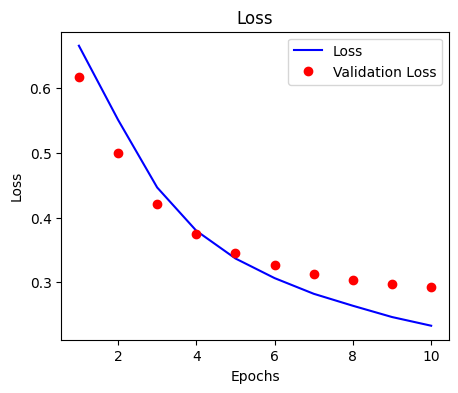

In [77]:
plt.figure(figsize=(5,4))
plt.plot(epochs, loss, 'b', label='Loss')
plt.plot(epochs, val_loss, 'ro', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs'),
plt.ylabel('Loss')
plt.legend()
plt.show()


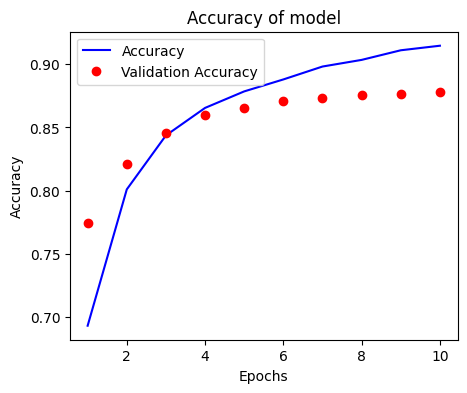

In [79]:
plt.figure(figsize=(5,4))
plt.plot(epochs, binary_accuracy, 'b', label='Accuracy')
plt.plot(epochs, val_binary_accuracy, 'ro', label='Validation Accuracy')
plt.title('Accuracy of model')
plt.xlabel('Epochs'),
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.



In [81]:
export_model = tf.keras.Sequential([
  vactorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)


782/782 [==============================] - 12s 12ms/step - loss: 0.3103 - accuracy: 0.8734
0.8733599781990051


In [83]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)


1/1 [==============================] - 0s 174ms/step


array([[0.62393343],
       [0.448426  ],
       [0.36364537]], dtype=float32)